In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import optdmd
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
t_step = 0.001
f1 = 4
t1 = np.arange(-500,1200)+500
f2 = 30
t2 = np.arange(-500,1200)+500
f3 = 17
t3 = np.arange(800,2500)+500
f4 = 30
t4 = np.arange(800,2500)+500

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(0,30,10)]]),\
                    t_step, \
                    utils.create_decay(len(t1),1,400))
net2, F2_true, _  = utils.make_network(f2, len(t2), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-20,30,10)]]),\
                    t_step, \
                    utils.create_decay(len(t2),1,400))
net3, F3_true, _  = utils.make_network(f3, len(t3), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,0,10)]]),\
                    t_step, \
                    utils.create_decay(len(t3),400,1))
gauss = scipy.stats.norm(800, 200).pdf(np.arange(1700))
gauss = gauss / np.max(gauss) + 0.3
net4, F4_true, _  = utils.make_network(f4, len(t4), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(10,-40,10)]]),\
                    t_step, \
                    gauss*utils.create_decay(len(t4),400,1))
x = np.zeros((100,3000))
x[:,t1] += net1
x[:,t2] += net2
x[:,t3] += net3
x[:,t4] += net4
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) * t_step

Text(0, 0.5, 'Channel')

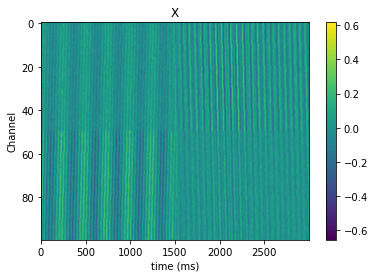

In [3]:
plt.imshow(x, aspect='auto')
plt.colorbar()
plt.title('X')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

In [4]:
w_len = 500
stride = 100
rank = 4
freqs, phis, windows = nsdmd.opt_dmd_win(x, t, w_len, stride, rank)
x_extent = np.mean(t[windows], axis=1)

Text(0, 0.5, 'Freq (Hz)')

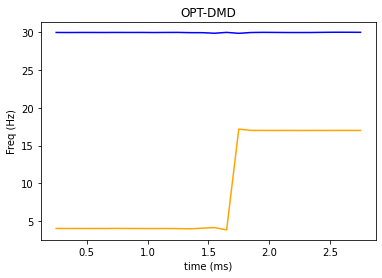

In [5]:
colors=['blue','orange','green','red']
for j, i in enumerate(range(0,rank,2)):
    plt.plot(x_extent, freqs[:,i], color=colors[j])
plt.title('OPT-DMD')
plt.xlabel('time (ms)')
plt.ylabel('Freq (Hz)')

In [6]:
soln = nsdmd.get_soln(freqs, phis, t, t[windows[:,0]])
soln_r = np.transpose(soln, (1,0,2,3)).reshape((-1, soln.shape[2], soln.shape[3]))

In [7]:
t_delay = nsdmd.get_t_delay_from_soln(freqs, phis, t, t_step, t[windows[:,0]])
t_delay_r = np.transpose(t_delay, (1,0,2)).reshape((-1, t_delay.shape[2]))

Text(0.5, 1.0, 'Similar Solutions')

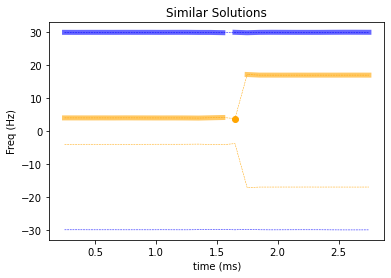

In [8]:
group_idx = nsdmd.group_by_similarity(freqs, phis, thresh_phi_amp=0.9)
    
sub_idx = []
for i, groups in enumerate(group_idx):
    for g in groups:
        sub_idx.append(np.random.choice(g) + i*(group_idx[-2][-1][-1]+1))
sub_idx = np.array(sub_idx)
sub_idx = sub_idx[np.sum(np.sum(soln_r[sub_idx], axis=2), axis=1)!=0] #In case trivial solutions get through

colors = ['blue', 'orange', 'green', 'red']
for i in range(len(group_idx)):
    plt.plot(x_extent, freqs[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            plt.plot(x_extent[g], freqs[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            plt.scatter(x_extent[g], freqs[g,i], color=colors[i//2])
plt.xlabel('time (ms)')
plt.ylabel('Freq (Hz)')
plt.title('Similar Solutions')

In [9]:
import imp
imp.reload(nsdmd)

<module 'nsdmd.nsdmd' from '/home/jovyan/nsdmd/nsdmd/nsdmd.py'>

In [10]:
B,f = nsdmd.exact_Bf(x, soln_r[sub_idx])

In [11]:
B.shape

(5, 5, 3000)

In [ ]:
# idx_all, total_error = get_reduced_F(B,G,soln_r[sub_idx],x,30)